## LSTM

## Setup

In [1]:
import sys
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

C:\Users\Ananya\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [5]:
# Read in data
forex = pd.read_csv('./GBPUSD.csv')
model_scores = pd.read_csv("./Model scores.csv", index_col=0)

# Convert series into datetime type
forex.index = pd.to_datetime(forex['Date'])

# Save target series
series = forex['Close']

#Size of exchange rates
total_size = forex.shape[0]
print(total_size)

#Use 80% of data as training, rest 10% to Validate and Test the model
valid_split_index = int(total_size * 0.8)
test_split_index = int(total_size * 0.1)
x_train = forex.iloc[0:valid_split_index].Close
x_valid = forex.iloc[valid_split_index:-test_split_index].Close
x_test = forex.iloc[-test_split_index:total_size].Close

model_scores

4852


,Model,MAE,MAPE in %
0,Naive Model,0.004958,0.374773
1,MA5,0.011715,0.890453
2,MA20,0.024235,1.840606
3,"ARIMA (0,1,0)",0.004958,0.374773
4,"Linear model (MA5, MA20)",0.005484,0.414356
5,Dense Neural Network,0.011224,0.858841
6,LSTM,0.002854,0.211474
7,RNN,0.005412,0.410384


In [6]:
# Reshape the datsets
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

# Create a Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# normalize training data
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# normalize validation data
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# normalize test data
normalized_x_test = x_train_scaler.transform(x_test_values)

# Normalized to training data
forex_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [9]:
# Used as callback to reset model state, since this is a stateful model
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [8]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# run simulations for optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
193/193 [==============================] - 7s 19ms/step - loss: 0.2565 - mae: 0.4391 - lr: 1.0000e-05
Epoch 2/100
193/193 [==============================] - 2s 11ms/step - loss: 0.1163 - mae: 0.2716 - lr: 1.1220e-05
Epoch 3/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0131 - mae: 0.0784 - lr: 1.2589e-05
Epoch 4/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0028 - mae: 0.0348 - lr: 1.4125e-05
Epoch 5/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0027 - mae: 0.0333 - lr: 1.5849e-05
Epoch 6/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0025 - mae: 0.0322 - lr: 1.7783e-05
Epoch 7/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0024 - mae: 0.0313 - lr: 1.9953e-05
Epoch 8/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0023 - mae: 0.0303 - lr: 2.2387e-05
Epoch 9/100
193/193 [==============================] - 2s 11ms/step - loss: 0.0022 - mae

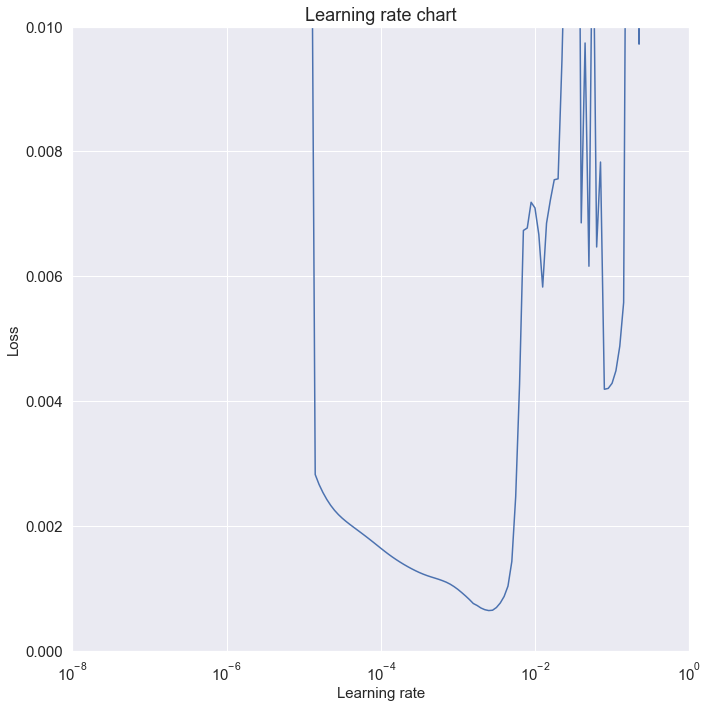

In [9]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title('Learning rate chart', fontsize=18)
plt.xlabel('Learning rate', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([1e-8, 1, 0, 0.01])
plt.tight_layout()
plt.show()

## grid search to find optimal model

In [12]:
# create a list of configs to try
def model_configs():
    config = {}
    # define scope of configs
    n_epochs = [100, 500]
    optimizers = [keras.optimizers.Adam(learning_rate=1e-3), keras.optimizers.Nadam(learning_rate=1e-3), keras.optimizers.SGD(learning_rate=1e-3), keras.optimizers.Adagrad(learning_rate=1e-3)]
    losses = [keras.losses.MeanSquaredError(), keras.losses.MeanAbsoluteError()]
    # Make a dictionary of the grid search parameters
    configs = list()
    for epoch in n_epochs:
        for optim in optimizers:
            for loss in losses:
                param_grids = dict(optimizers = optim, loss = loss, epochs=epoch)    # create configs
                configs.append(param_grids)
    print('Total configs: %d' % len(configs))
    return configs

configs = model_configs()
len(configs)

Total configs: 16


16

In [ ]:
from tqdm.notebook import tqdm, trange

# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

x=1

for config in tqdm(configs, desc="Progress"):
    # create model
    model = keras.models.Sequential([
      keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
      keras.layers.LSTM(100, return_sequences=True, stateful=True),
      keras.layers.Dense(1),
    ])

    # set optimizer
    optimizer = config["optimizers"]

    # compile model
    model.compile(loss=config["loss"],
                  optimizer=optimizer,
                  metrics=["mae"])

    # reset states
    reset_states = ResetStatesCallback()

    #set up save best only checkpoint
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint_lstm_"+str(x), save_best_only=True, verbose=0)

    x = x+1

    early_stopping = keras.callbacks.EarlyStopping(patience=50)

    # fit model
    model.fit(train_set, epochs=config["epochs"],
              validation_data=valid_set,
              callbacks=[early_stopping, model_checkpoint, reset_states], verbose=0)

Progress:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_1\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


INFO:tensorflow:Assets written to: my_checkpoint_lstm_2\assets


In [ ]:
mae_df = pd.DataFrame(columns=["MAE score", "config"])
   
for a in range(1, 17):
    config = configs[a-1]
    optim = config["optimizers"].__class__.__name__
    loss = config["loss"].__class__.__name__
    
    config_list = (config["epochs"], optim, loss)
    
    model = keras.models.load_model("my_checkpoint_lstm_"+str(a))
    dense_forecast = model_forecast(model, forex_normalized_to_traindata.flatten()[-test_split_index - window_size:-1], window_size)[:, 0]
    # Undo the scaling
    dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
    mae_score = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()
    
    mae_df.loc[len(mae_df.index)] = [mae_score, config_list]

mae_df = mae_df.sort_values(by = "MAE score")
print(mae_df)

In [ ]:
mae_df.to_csv("LSTM simulations")

## Build and Train LSTM Model with optimal configuration

In [ ]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)

# compile model
model.compile(loss="mean_absolute_error",
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

# save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

## Make Predictions

In [ ]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [13]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()

In [14]:
# inverse the scaling/normalization applied to data earlier
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(485,)

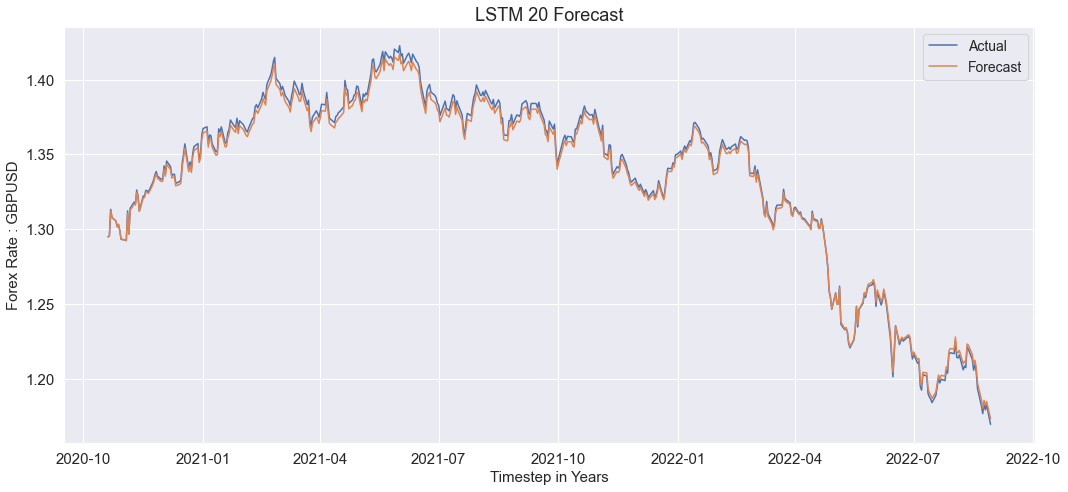

In [15]:
# plot results
plt.figure(figsize=(15, 7))
plt.title(f'LSTM {window_size} Forecast', fontsize=18)
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.tight_layout()
plt.show()

In [18]:
# MAE
lstm_mae = keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
lstm_mape = mean_absolute_percentage_error(x_test, rnn_unscaled_forecast) * 100

# add scores alongside its name 
model_scores.loc[len(model_scores.index)] = ["LSTM", lstm_mae, lstm_mape]

# view the dataframe of scores
model_scores

,Model,MAE,MAPE in %
0,Naive Model,0.004958,0.374773
1,MA5,0.011715,0.890453
2,MA20,0.024235,1.840606
3,"ARIMA (0,1,0)",0.004958,0.374773
4,"Linear model (MA5, MA20)",0.005484,0.414356
5,Dense Neural Network,0.011224,0.858841
6,LSTM,0.002854,0.211474


In [19]:
model_scores.to_csv("./Model scores.csv")